# Debugging the Bottleneck Model in Detail

## Importing stuff

In [7]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import json
from collections import OrderedDict
import moments
import dadi
sys.path.append("/projects/kernlab/akapoor/Demographic_Inference/")

In [8]:
experiment_config_filepath = '/projects/kernlab/akapoor/Demographic_Inference/experiment_config.json'

## Step 1: Simulation

In [ ]:
from snakemake_scripts.single_simulation import main

In [9]:
sim_directory = '/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences'
sim_number = 0

In [ ]:
main(experiment_config_filepath, sim_directory, sim_number)

Let's examine the contents

In [5]:
with open(f'{sim_directory}/simulation_results/sampled_params_{sim_number}.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

In [6]:
sampled_params

{'N0': 17492,
 'Nb': 870,
 'N_recover': 24038,
 't_bottleneck_start': 1400,
 't_bottleneck_end': 313}

## Step 2: Genome Window VCFs

In [ ]:
from snakemake_scripts.obtain_genome_vcfs import main as main_genome_vcf

In [ ]:
#tree_sequence_file, experiment_config_filepath, genome_sim_directory, window_number, sim_number

tree_sequence_file = f'/sietch_colab/akapoor/Demographic_Inference/sims/simulation_results/ts_sim_{sim_number}.trees'
genome_sim_directory = '/sietch_colab/akapoor/Demographic_Inference/genome_windows_test'

for window_number in tqdm(range(100)):
    main_genome_vcf(tree_sequence_file, experiment_config_filepath, genome_sim_directory, window_number, sim_number)


## Step 3: LD Stats

In [ ]:
# ld_stat_creation(vcf_filepath, flat_map_path, pop_file_path, sim_directory, sim_number, window_number)

In [ ]:
from snakemake_scripts.ld_stats import ld_stat_creation

In [ ]:
sim_directory = '/sietch_colab/akapoor/Demographic_Inference/ld_stats_test'
for window_number in tqdm(range(100)):
    vcf_filepath = f'/sietch_colab/akapoor/Demographic_Inference/genome_windows_test/window_{window_number}/window.{window_number}.vcf.gz'
    flat_map_path = f'/sietch_colab/akapoor/Demographic_Inference/genome_windows_test/window_{window_number}/flat_map.txt'
    pop_file_path = f'/sietch_colab/akapoor/Demographic_Inference/genome_windows_test/window_{window_number}/samples.txt'
    ld_stat_creation(vcf_filepath, flat_map_path, pop_file_path, sim_directory, sim_number, window_number)
    

### Step 3.1: Gather the LD stats

In [ ]:
BASE_DIR = '/sietch_colab/akapoor/Demographic_Inference'

def gather_ld_stats(sim_number, experiment_config):
    """
    Collects and combines LD statistics for a given simulation number.

    Args:
        sim_number (int): Simulation number to process.
        experiment_config (dict): Configuration containing the number of windows.

    Saves:
        A combined pickle file for all windows in the given simulation.
    """
    # Define input file paths
    ld_stats_files = [
        os.path.join(BASE_DIR, f"ld_stats_test/sim_{sim_number}/window_{window_number}/ld_stats_window.{window_number}.pkl")
        for window_number in range(experiment_config["num_windows"])
    ]

    # Ensure output directory exists
    output_dir = os.path.join(BASE_DIR, f"combined_LD_inferences_test/sim_{sim_number}")
    os.makedirs(output_dir, exist_ok=True)

    # Output file path
    output_file = os.path.join(output_dir, f"combined_LD_stats_sim_{sim_number}.pkl")

    # Initialize combined dictionary
    combined_data = {}

    # Collect and merge LD statistics from all window files
    for window_number, file in enumerate(ld_stats_files):
        if os.path.exists(file):  # Ensure file exists before loading
            with open(file, "rb") as f:
                data = pickle.load(f)  # Expecting a dictionary per file

                if not isinstance(data, dict):
                    print(f"Warning: {file} does not contain a dictionary, skipping.")
                    continue  # Skip files that are not dicts

                # Ensure window index is preserved
                combined_data[window_number] = data

    # Save combined data in correct format
    with open(output_file, "wb") as f:
        pickle.dump(combined_data, f)

    print(f"Successfully saved combined LD statistics to {output_file}")

In [ ]:
with open(experiment_config_filepath, "r") as f:
    experiment_config = json.load(f)
    
gather_ld_stats(sim_number, experiment_config)

## Step 4: MomentsLD Inference

In [ ]:
from snakemake_scripts.momentsLD_analysis import main as momentsLD_func

In [ ]:
experiment_config_filepath

In [ ]:
combined_ld_stats_path = f'/sietch_colab/akapoor/Demographic_Inference/combined_LD_inferences_test/sim_{sim_number}/combined_LD_stats_sim_{sim_number}.pkl'
sim_directory = f'/sietch_colab/akapoor/Demographic_Inference/MomentsLD_inferences_test/sim_{sim_number}'
os.makedirs(sim_directory, exist_ok=True)
sampled_params_path = f'/sietch_colab/akapoor/Demographic_Inference/sims/simulation_results/sampled_params_{sim_number}.pkl'

In [ ]:
with open(combined_ld_stats_path, 'rb') as f:
    ld_stats = pickle.load(f)

In [ ]:
ld_stats

In [ ]:
momentsLD_func(combined_ld_stats_path, sampled_params_path, experiment_config_filepath, sim_directory, sim_number)

In [ ]:
sampled_params

In [ ]:
with open('/sietch_colab/akapoor/Demographic_Inference/MomentsLD_inferences_test/sim_0/momentsLD_inferences_sim_0.pkl', 'rb') as f:
    momentsLD_inferences = pickle.load(f)

In [ ]:
momentsLD_inferences

## Moments / Dadi 

The problem is that we want to optimize only N0, N_bottleneck, N_recovery, and t_bottleneck_end. But the demes integration takes all of the parameters (including t_bottleneck_start). 

In [10]:
sim_number = 1
with open(f'/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/simulation_results/sampled_params_{sim_number}.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

replicate_number = 0
SFS = f'{sim_directory}/simulation_results/SFS_sim_{sim_number}.pkl'
print(f'The simulation directory is: {sim_directory}')

# Ensure required directories exist
dadi_dir = f"{sim_directory}/sim_{sim_number}/dadi/replicate_{replicate_number}"
moments_dir = f"{sim_directory}/sim_{sim_number}/moments/replicate_{replicate_number}"

print(f'The dadi dir is {dadi_dir}')
print(f'The moments dir is {moments_dir}')

os.makedirs(dadi_dir, exist_ok=True)
os.makedirs(moments_dir, exist_ok=True)

# Load in the experiment config 
with open(experiment_config_filepath, "r") as f:
    experiment_config = json.load(f)

# # It's strange because we also want to optimize the ancestral size but indirectly through theta. Therefore, the ancestral population size will not be an element in the upper or lower bounds
# param_order = experiment_config["parameter_names"]
# p0 = [experiment_config["optimization_initial_guess"][param] for param in param_order]
# lower_bound = [experiment_config["lower_bound_optimization"][param] for param in param_order]
# upper_bound = [experiment_config["upper_bound_optimization"][param] for param in param_order]

# # 4) Perturb the initial guess to avoid local minima #TODO: Make sure that this doesn't affec the t_bottleneck_start value
# p_guess = moments.Misc.perturb_params(
#     p0, fold=1, lower_bound=lower_bound, upper_bound=upper_bound
# )


The simulation directory is: /projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences
The dadi dir is /projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_1/dadi/replicate_0
The moments dir is /projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_1/moments/replicate_0


In [22]:
p_guess

array([ 6203.13018762,   702.18258335, 17305.66368808,  1713.2223483 ,
         165.3820506 ])

In [23]:
if experiment_config["demographic_model"] == "bottleneck_model":
    fixed_tb_start = sampled_params['t_bottleneck_start']
    # p_guess[3] = fixed_tb_start

    # Set the same fixed value across all relevant fields
    experiment_config["lower_bound_optimization"]["t_bottleneck_start"] = fixed_tb_start
    experiment_config["upper_bound_optimization"]["t_bottleneck_start"] = fixed_tb_start
    experiment_config["optimization_initial_guess"]["t_bottleneck_start"] = fixed_tb_start


# It's strange because we also want to optimize the ancestral size but indirectly through theta. Therefore, the ancestral population size will not be an element in the upper or lower bounds
# param_order = experiment_config["parameter_names"]
# p0 = [experiment_config["optimization_initial_guess"][param] for param in param_order]
lower_bound = [experiment_config["lower_bound_optimization"][param] for param in param_order]
upper_bound = [experiment_config["upper_bound_optimization"][param] for param in param_order]

print(f'The parameter order is: {param_order}')
p_guess= [experiment_config["optimization_initial_guess"][param] for param in param_order]
print(f'The guess is: {p_guess}')
print(f'The upper bound is: {upper_bound}')
print(f'The lower bound is: {lower_bound}')

upper_bound = list(experiment_config['upper_bound_optimization'].values())
lower_bound = list(experiment_config['lower_bound_optimization'].values())

# Load in the SFS file
with open(SFS, "rb") as f:
    sfs = pickle.load(f)

The parameter order is: ['N0', 'Nb', 'N_recover', 't_bottleneck_start', 't_bottleneck_end']
The guess is: [10000, 800, 20000, 1666, 300]
The upper bound is: [20000, 1000, 30000, 1666, 500]
The lower bound is: [5000, 500, 10000, 1666, 100]


In [24]:
demographic_model = experiment_config['demographic_model']
pop_ids = None

if demographic_model == "split_migration_model":
    pop_ids = ['N1', 'N2']
elif demographic_model == "split_isolation_model":
    pop_ids = ['N1', 'N2']
elif demographic_model == "bottleneck_model":
    pop_ids = ['N0']
else:
    raise ValueError(f"Unsupported demographic model: {demographic_model}")

sfs.pop_ids = pop_ids

sample_sizes_fit = OrderedDict(
    (p, (n - 1)//2) for p, n in zip(sfs.pop_ids, sfs.shape)
)
ns = sfs.sample_sizes

# print(f"lower bound: {lower_bound}")
# print(f"upper bound: {upper_bound}")

# 1) Build "mean" and "stddev" from your (scaled) bounds
mean = [(l+u)/2 for (l, u) in zip(lower_bound, upper_bound)]
stddev = [(u - l)/np.sqrt(12) for (l, u) in zip(lower_bound, upper_bound)]

# 3) Setup grids for extrapolation
pts_ext = [max(ns) + 60, max(ns) + 70, max(ns) + 80]

# 4) Perturb the initial guess to avoid local minima #TODO: Make sure that this doesn't affec the t_bottleneck_start value
# p_guess = moments.Misc.perturb_params(
#     p0, fold=1, lower_bound=lower_bound, upper_bound=upper_bound
# )

# p_guess = p0.copy()


In [25]:
p_guess

[10000, 800, 20000, 1666, 300]

In [26]:
def diffusion_sfs_dadi(
    parameters: list[float],
    sample_sizes: OrderedDict,
    demographic_model: str,
    mutation_rate: float,
    sequence_length: float,
    pts: list[int],
) -> dadi.Spectrum:
    """
    Get the expected SFS under the diffusion approximation (using dadi)
    by building a demes.Graph and converting to a dadi model via demes_dadi.

    Parameters
    ----------
    parameters : list[float]
        Model parameters in demographic units or scaled units
        (depending on how your demes builder interprets them).
    sample_sizes : OrderedDict
        e.g. {"N1": 15, "N2": 8} for 2D data
    demographic_model : str
        One of ["split_migration_model", "split_isolation_model", "bottleneck_model"].
    mutation_rate : float
        Mutation rate per generation per base.
    sequence_length : float
        Total number of base pairs or length of region.
    pts : list of int
        Extrapolation grid sizes for dadi (e.g. [60, 70, 80]).

    Returns
    -------
    dadi.Spectrum
        The model-predicted SFS (on the largest grid in `pts`).
    """
    # 1) Parse the parameters and pick the correct demes-based function
    # parameters.insert(0,10000) # Insert the ancestral pop size. 
    
    if demographic_model == "split_migration_model":
        # For example, [N0, N1, N2, m12, m21, t_split]
        param_dict = {
            "N0": parameters[0],
            "N1": parameters[1],
            "N2": parameters[2],
            "m12": parameters[3],
            "m21": parameters[4],
            "t_split": parameters[5],
        }
        demo_func = demographic_models.split_migration_model_simulation

    elif demographic_model == "split_isolation_model":
        # For example, [N0, N1, N2, m, t_split]
        param_dict = {
            "Na": parameters[0],
            "N1": parameters[1],
            "N2": parameters[2],
            "m": parameters[4],
            "t_split": parameters[3],
        }
        demo_func = demographic_models.split_isolation_model_simulation

    elif demographic_model == "bottleneck_model":
        # For example, [N0, Nb, N_recover, t_bottleneck_end, ...]
        # Adjust indexing to match your code.
        param_dict = {
            "N0": parameters[0],
            "Nb": parameters[1],
            "N_recover": parameters[2],
            "t_bottleneck_start": parameters[3],
            "t_bottleneck_end": parameters[4],
            # etc. if more parameters
        }
        demo_func = demographic_models.bottleneck_model

    else:
        raise ValueError(f"Unsupported demographic model: {demographic_model}")

    # 2) Build the demes graph
    start = time.time()
    demes_graph = demo_func(param_dict)  # e.g. returns a demes.Graph
    end = time.time()

    # print(f'TIME TO BUILD DEMES GRAPH: {end - start}')

    # 3) Convert the demes Graph to a dadi function using demes_dadi
    #    This creates a python function: model_func(pts, ns, [params]) -> fs
    #    But the demes graph is already fully specified. We just pass it in.
    # dadi_model_func = demes_dadi.Demes2Dadi(demes_graph)

    # 4) Evaluate on the extrapolation grid
    #    For a 2D model, sample_sizes might be [n1, n2]. For 1D, [n]. For 3D, etc.
    ns = [2 * n for n in sample_sizes.values()]  # e.g., [30, 16] if input is [15, 8]
    # print(f'SAMPLE SIZES: {ns}')

    start = time.time()

    model_fs = dadi.Spectrum.from_demes(
        demes_graph,
        sampled_demes = list(sample_sizes.keys()),
        sample_sizes = ns,
        pts = pts
    )

    end = time.time()

    # print(f'TIME TO BUILD SFS: {end - start}')
    
    # model_fs = dadi_model_func(pts, ns)

    # 5) Scale by theta if you want an absolute SFS. Typically, we do:
    #    theta = 4 * Nref * mu * L. If you consider parameters[0] = N0, then:
    Nref = parameters[0]
    theta = 4.0 * Nref * mutation_rate * sequence_length

    model_fs *= theta

    # model_fs is a dadi.Spectrum. You can return it directly.
    # print(f'Diffusion SFS Dadi: {model_fs}')
    # print(f'Diffusion SFS Dadi Shape: {model_fs.shape}')
    return model_fs


In [28]:
import src.demographic_models as demographic_models
import time
import nlopt
def raw_wrapper(scaled_params, ns, pts):
    # scaled_params = unnorm(z_params, mean, stddev)
    # print(f'unscaled Parameters are: {scaled_params}')
    # print(f'The params are: {scaled_params}')
    return diffusion_sfs_dadi(
        scaled_params,
        sample_sizes_fit,
        demographic_model,
        mutation_rate = experiment_config['mutation_rate'],
        sequence_length = experiment_config['genome_length'],
        pts = pts
    )

# 3) Extrapolation function
func_ex = dadi.Numerics.make_extrap_func(raw_wrapper)

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')

popt, ll_model = dadi.Inference.opt(
    p_guess,
    sfs, 
    func_ex,
    pts=pts_ext,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    algorithm=nlopt.LN_BOBYQA,
    maxeval=1000,
    verbose=1
)
# xopt = dadi.Inference.optimize_log_powell(
#     p_guess,
#     sfs,
#     func_ex,
#     pts=pts_ext,
#     lower_bound=lower_bound,
#     upper_bound=upper_bound,
#     multinom=False,
#     verbose=0,
#     flush_delay=0.0,
#     full_output=True,
#     maxiter=1000
# )

# fitted_params = xopt[0]
# ll_value = xopt[1]

# # fitted_params = unnorm(opt_params_z, mean, stddev)
# print(f"Best-fit dadi params (real-space): {fitted_params}")

# # 5) Convert best-fit from z-space to real (scaled) space
# # print(f'The initial guess in real space is: {unnorm(init_z, mean, stddev)}')
# print(f'The optimized parameters in real space are : {fitted_params}')


Lower bound: [5000, 500, 10000, 1666, 100]
Upper bound: [20000, 1000, 30000, 1666, 500]
87      , -5254.87    , array([ 10000      ,  800        ,  20000      ,  1666       ,  300        ])
88      , -8320.76    , array([ 13750      ,  800        ,  20000      ,  1666       ,  300        ])
89      , -5780.65    , array([ 10000      ,  925        ,  20000      ,  1666       ,  300        ])
90      , -5067.84    , array([ 10000      ,  800        ,  25000      ,  1666       ,  300        ])
91      , -3902.23    , array([ 10000      ,  800        ,  20000      ,  1666       ,  400        ])
92      , -1959.82    , array([ 6250       ,  800        ,  20000      ,  1666       ,  300        ])
93      , -4463.02    , array([ 10000      ,  675        ,  20000      ,  1666       ,  300        ])
94      , -5516.97    , array([ 10000      ,  800        ,  15000      ,  1666       ,  300        ])
95      , -7411.96    , array([ 10000      ,  800        ,  20000      ,  1666       ,  200     

In [29]:
print(popt)

[ 5000.           565.89448696 11144.63743432  1666.
   459.36241552]


In [32]:
with open('/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/simulation_results/sampled_params_1.pkl', 'rb') as f:
    sampled_params = pickle.load(f)
sampled_params

{'N0': 5174,
 'Nb': 555,
 'N_recover': 10156,
 't_bottleneck_start': 1666,
 't_bottleneck_end': 474}

In [25]:
from snakemake_scripts.obtain_single_feature import obtain_feature as obtain_feature_dadi_moments

In [26]:
for i in range(10):
    sim_number = i 
    SFS = f'{sim_directory}/simulation_results/SFS_sim_{sim_number}.pkl'
    replicate_number = 0
    sampled_params_path = f'{sim_directory}/simulation_results/sampled_params_{sim_number}.pkl'
    # print(f'The simulation directory is: {sim_directory}')
    
    # Ensure required directories exist
    dadi_dir = f"{sim_directory}/sim_{sim_number}/dadi/replicate_{replicate_number}"
    moments_dir = f"{sim_directory}/sim_{sim_number}/moments/replicate_{replicate_number}"
    
    # print(f'The dadi dir is {dadi_dir}')
    # print(f'The moments dir is {moments_dir}')
    
    os.makedirs(dadi_dir, exist_ok=True)
    os.makedirs(moments_dir, exist_ok=True)

    obtain_feature_dadi_moments(SFS, sampled_params_path, experiment_config_filepath, sim_directory, sim_number, replicate_number)

The simulation directory is: /projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences
The dadi dir is /projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/dadi/replicate_0
The moments dir is /projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/moments/replicate_0
The guess is: [10000, 800, 20000, 1400, 300]
The upper bound is: [20000, 1000, 30000, 1900, 500]
The lower bound is: [5000, 500, 10000, 900, 100]
Lower bound: [5000, 500, 10000, 900, 100]
Upper bound: [20000, 1000, 30000, 1900, 500]
1       , -25834.3    , array([ 10000      ,  800        ,  20000      ,  1400       ,  300        ])
2       , -25834.3    , array([ 10000      ,  800        ,  20000      ,  1400       ,  300        ])
5       , -78814.6    , array([ 5390.03    ,  800        ,  20000      ,  1400       ,  300        ])
6       , -5484.43    , array([ 14651.6    ,  800        ,  20000      ,  1400       ,  300     

In [19]:
with open('/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/moments/replicate_0/replicate_0.pkl', 'rb') as f:
    moments_inferences = pickle.load(f)

In [20]:
moments_inferences['opt_params_moments']

{'N0': 17251.612243733278,
 'Nb': 920.091840556105,
 'N_recover': 17714.996561085096,
 't_bottleneck_start': 1395.1987049877157,
 't_bottleneck_end': 314.9532412653182,
 'll': 355.2422933036014,
 'upper_triangular_FIM': array([-2.17960126e-01,  1.01777729e-04,  0.00000000e+00, -2.97279253e-02,
         2.96768626e-06,  0.00000000e+00, -7.61580566e-04,  0.00000000e+00,
         0.00000000e+00, -1.65476791e-01])}

In [21]:
with open('/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/simulation_results/sampled_params_0.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

sampled_params

{'N0': 17492,
 'Nb': 870,
 'N_recover': 24038,
 't_bottleneck_start': 1400,
 't_bottleneck_end': 313}

In [22]:
with open('/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/dadi/replicate_0/replicate_0.pkl', 'rb') as f:
    dadi_inferences = pickle.load(f)

In [23]:
dadi_inferences['opt_params_dadi']

{'N0': 16997.690166416083,
 'Nb': 500.00017861501186,
 'N_recover': 15106.821942895502,
 't_bottleneck_end': 389.6758064496901,
 'll': 344.082698202501}

In [24]:
sampled_params

{'N0': 17492,
 'Nb': 870,
 'N_recover': 24038,
 't_bottleneck_start': 1400,
 't_bottleneck_end': 313}

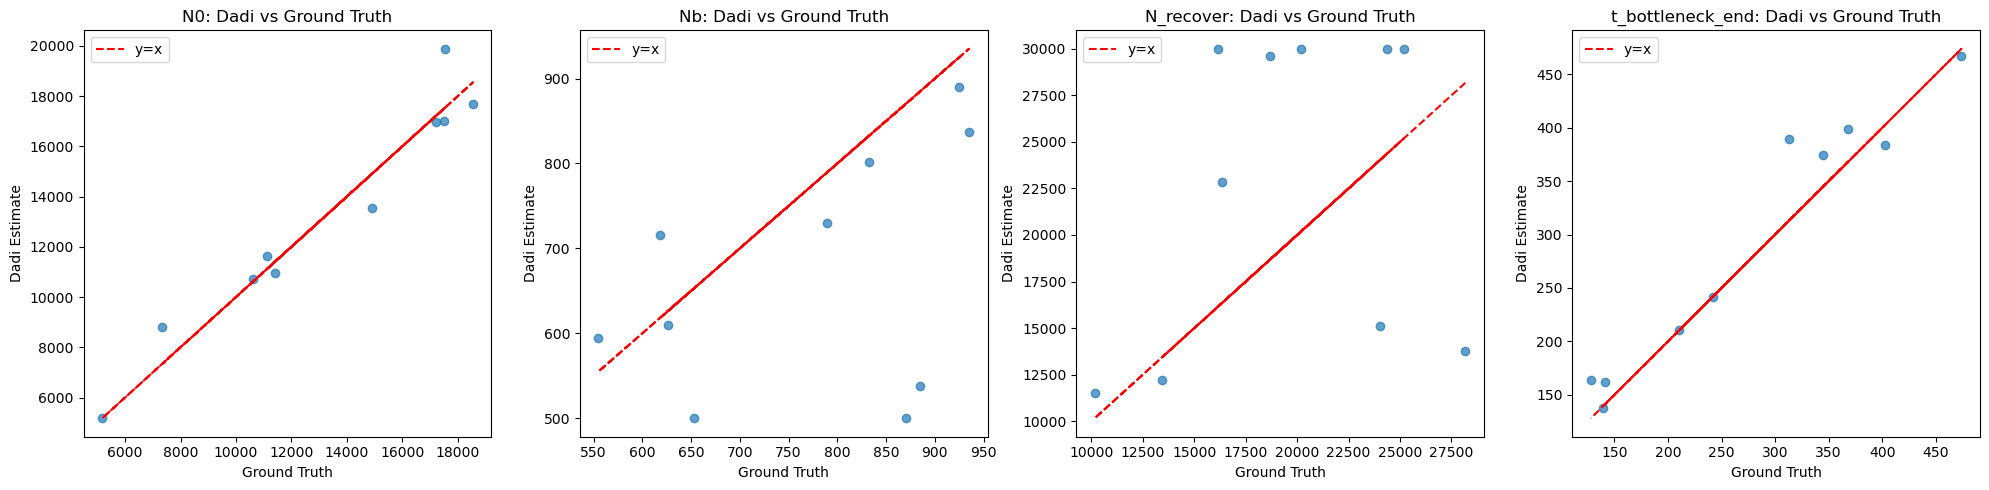

In [27]:
import os
import pickle
import matplotlib.pyplot as plt

# Directories
root_dir = "/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences"
num_sims = 10
first_replicate = 0  # Use replicate_0 for simplicity

ground_truths = []
dadi_estimates = []

for sim_number in range(num_sims):
    # Load sampled_params from original directory
    sampled_path = f"/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/simulation_results/sampled_params_{sim_number}.pkl"
    try:
        with open(sampled_path, "rb") as f:
            true_params = pickle.load(f)
    except Exception as e:
        print(f"Missing or broken: {sampled_path}")
        continue

    # Load dadi result from new path
    dadi_path = os.path.join(
        # '/projects/kernlab/akapoor/Demographic_Inference/moments_dadi_features/',
        root_dir,
        f"sim_{sim_number}",
        "dadi",
        f"replicate_{first_replicate}",
        f"replicate_{first_replicate}.pkl"
    )

    try:
        with open(dadi_path, "rb") as f:
            dadi_result = pickle.load(f)
            inferred_params = dadi_result.get("opt_params_dadi", {})
    except Exception as e:
        print(f"Missing or broken: {dadi_path}")
        continue

    # Filter parameters to match
    gt_filtered = {k: v for k, v in true_params.items() if k in inferred_params and k not in ["t_bottleneck_start", "ll"]}
    est_filtered = {k: inferred_params[k] for k in gt_filtered}

    ground_truths.append(gt_filtered)
    dadi_estimates.append(est_filtered)

# Get all parameter names (excluding 'll' and 't_bottleneck_start')
if ground_truths:
    params_to_plot = ground_truths[0].keys()
else:
    print("No data to plot.")
    exit()

# Plot
num_params = len(params_to_plot)
fig, axes = plt.subplots(1, num_params, figsize=(5 * num_params, 5))

if num_params == 1:
    axes = [axes]

for ax, param in zip(axes, params_to_plot):
    gt_vals = [d[param] for d in ground_truths]
    est_vals = [d[param] for d in dadi_estimates]

    ax.scatter(gt_vals, est_vals, alpha=0.7)
    ax.plot(gt_vals, gt_vals, 'r--', label='y=x')
    ax.set_title(f"{param}: Dadi vs Ground Truth")
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Dadi Estimate")
    ax.legend()

plt.tight_layout()
plt.show()


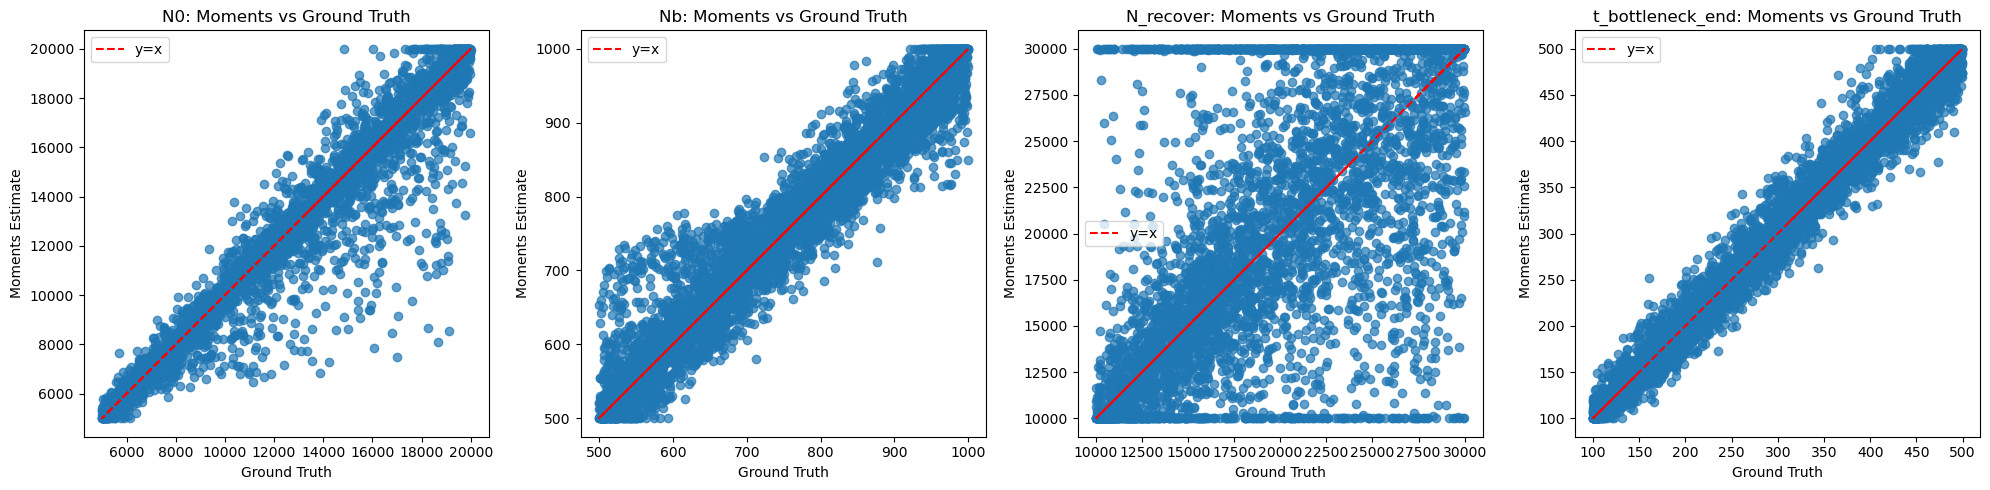

In [2]:
import os
import pickle
import matplotlib.pyplot as plt

# Directories
root_dir = "/projects/kernlab/akapoor/Demographic_Inference/simulated_parameters_and_inferences"
num_sims = 5000
first_replicate = 0  # Use replicate_0 for simplicity

ground_truths = []
moments_estimates = []

for sim_number in range(num_sims):
    # Load sampled_params
    sampled_path = os.path.join(root_dir, 'simulation_results', f"sampled_params_{sim_number}.pkl")
    try:
        with open(sampled_path, "rb") as f:
            true_params = pickle.load(f)
    except Exception as e:
        print(f"Missing or broken: {sampled_path}")
        continue

    # Load moments result
    moments_path = os.path.join(
        '/projects/kernlab/akapoor/Demographic_Inference/moments_dadi_features/',
        f"sim_{sim_number}",
        "moments",
        f"replicate_{first_replicate}",
        f"replicate_{first_replicate}.pkl"
    )

    try:
        with open(moments_path, "rb") as f:
            moments_result = pickle.load(f)
            inferred_params = moments_result.get("opt_params_moments", {})
    except Exception as e:
        print(f"Missing or broken: {moments_path}")
        continue

    # Exclude "ll" and "t_bottleneck_start" if present
    gt_filtered = {k: v for k, v in true_params.items() if k in inferred_params and k != "t_bottleneck_start" and k != "ll"}
    est_filtered = {k: inferred_params[k] for k in gt_filtered}

    ground_truths.append(gt_filtered)
    moments_estimates.append(est_filtered)

# Get all parameter names (excluding 'll' and 't_bottleneck_start')
params_to_plot = ground_truths[0].keys()

# Plot
num_params = len(params_to_plot)
fig, axes = plt.subplots(1, num_params, figsize=(5 * num_params, 5))

if num_params == 1:
    axes = [axes]

for ax, param in zip(axes, params_to_plot):
    gt_vals = [d[param] for d in ground_truths]
    est_vals = [d[param] for d in moments_estimates]

    ax.scatter(gt_vals, est_vals, alpha=0.7)
    ax.plot(gt_vals, gt_vals, 'r--', label='y=x')
    ax.set_title(f"{param}: Moments vs Ground Truth")
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Moments Estimate")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
with open('/sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/simulation_results/sampled_params_0.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

In [ ]:
with open('/sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/dadi/replicate_0/replicate_0.pkl', 'rb') as f:
    dadi_inferences = pickle.load(f)

with open('/sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/moments/replicate_0/replicate_0.pkl', 'rb') as f:
    moments_inferences = pickle.load(f)

In [ ]:
dadi_inferences['opt_params_dadi']

In [ ]:
moments_inferences['opt_params_moments']

In [ ]:
sampled_params

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Set the directory that contains the simulation results.
base_dir = "/sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences"
replicate = 0  # We use replicate_0

# List to hold fitted parameter dictionaries for each sim.
fitted_params_list = []

# Loop over simulation numbers 0 to 50 (inclusive)
for sim in range(50):
    file_path = os.path.join(
        base_dir,
        f"sim_{sim}",
        "dadi",
        f"replicate_{replicate}",
        f"replicate_{replicate}.pkl"
    )
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        # Here we assume your dadi inference pickle contains a dictionary with a key "opt_params_dadi"
        # which holds the fitted parameters (and possibly other keys).
        fitted = data.get("opt_params_dadi", None)
        if fitted is None:
            print(f"No fitted parameters found in {file_path}")
            continue
        fitted_params_list.append(fitted)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

if not fitted_params_list:
    raise ValueError("No fitted parameters were loaded.")

# Determine the parameter names (excluding 'll' if present)
param_names = [key for key in fitted_params_list[0].keys() if key != "ll"]

# Prepare a dictionary to store lists of values for each parameter.
param_values = {key: [] for key in param_names}

# Loop over each simulation’s fitted parameters and collect the values.
for params in fitted_params_list:
    for key in param_names:
        param_values[key].append(params[key])

# Plot histograms for each parameter.
num_params = len(param_names)
fig, axes = plt.subplots(num_params, 1, figsize=(6, 4 * num_params))

# If only one parameter, ensure axes is a list
if num_params == 1:
    axes = [axes]

for ax, key in zip(axes, param_names):
    values = np.array(param_values[key])
    ax.hist(values, bins=20, alpha=0.7, color='skyblue', edgecolor='k')
    ax.set_title(f"Distribution of {key}")
    ax.set_xlabel("Fitted value")
    ax.set_ylabel("Frequency")
    # Optionally add a line at the mean
    ax.axvline(values.mean(), color='red', linestyle='dashed', linewidth=1)

plt.tight_layout()
plt.show()
